<center>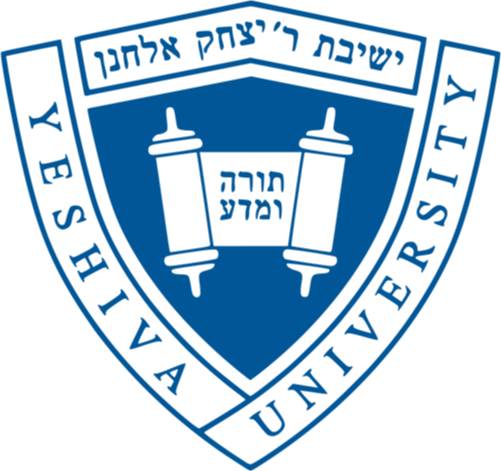</center>

# <center>Katz School of Science and Health</center>
# <center>AIM 5003 Numerical Methods</center>
<br>

# <center>Project 2: GPS, Solving Systems of Equations, Conditioning, and Nonlinear Least Squares</center>
<br><br>

### <center>Radek Jan Holik</center>
### <center>Pinxue Lin</center>
### <center>Rivka Shapiro</center>



# <a name="Contents">Table of Contents</a>
- [1 Multivariate Newton’s Method](#Section-1)
    - [1.1 Import the Necessary Libraries](#Section-11)
    - [1.2 Definition of the Nonlinear System](#Section-12)
    - [1.3 GPS Class and its Methods](#Section-13)
    - [1.4 Algorithm of Multivariate Newton's Method](#Section-14)
    - [1.5 Jacobian of the Given System](#Section-15)
    - [1.6 Solution by Multivariable Newton's Method](#Section-16)
    - [1.7 Convergence of the Algorithm](#Section-17)
    - [1.8 Plot of Errors](#Section-18)
<p>

- [2 Solution by the Quadratic Formula](#Section-2)
    - [2.1 The Number and Correctness of the Solutions](#Section-21)
    - [2.2 The Quality of the Solution Using the Quadratic Formula](#Section-22)
    - [2.3 Solution by the Quadratic Formula](#Section-23)
<p>

- [4 The Problem of Four Unbunched Satellites](#Section-4)
    - [4.1 GPS Spherical Coordinates](#Section-41)
    - [4.2 New Coordinates and Timing for the Satellites](#Section-42)
    - [4.3 Plot the Position of the Four Satellites](#Section-43)
    - [4.4 New Reference Solution x̄](#Section-44)
    - [4.5 Error Magnification Factor](#Section-45)
    - [4.6 Maximum Position Error](#Section-46)
    - [4.7 Condition Number](#Section-47)
<p>

- [5 Tightly Bounced Satellites](#Section-5)
    - [5.1 New GPS Spherical Coordinates](#Section-51)
    - [5.2 New Coordinates and Timing for the Satellites](#Section-52)
    - [5.3 Plot the Position of the Four Satellites](#Section-53)
    - [5.4 Reference x̄](#Section-54)
    - [5.5 Error Magnification Factor](#Section-55)
    - [5.6 Maximum Position Error](#Section-56)
    - [5.7 Condition Number](#Section-57)

<p>
    
- [6 The Effect of Adding More Satellites](#Section-6)
    - [6.1 New GPS Spherical Coordinates](#Section-61)
    - [6.2 New Coordinates and Timing for the Satellites](#Section-62)
    - [6.3 Plot the Position of the Eight Satellites](#Section-63)
    - [6.4 Algorithm of Gauss–Newton Method](#Section-64)
    - [6.5 Reference x̄](#Section-65)
    - [6.6 Basic Case Sold by Gauss-Newton Method](#Section-66)
    - [6.7 Initial Vector](#Section-67)
    - [6.8 Deciding on the Extremum of the Function F(x, y, z, d)](#Section-68)
    - [6.9 The Difference in Position and the Error Magnification Factor](#Section-69)
    - [6.10 Maximum Position Error](#Section-610)
    - [6.11 Condition Number](#Section-611)
    - [6.12 Other Combinations of Δt](#Section-612)
    - [6.13 Result of the Other Combinations of Δt](#Section-613)

 <p>   

- [7 Summary of the Results](#Section-7)

<p>

- [References](#Section-8)

# <a name="Section-1"> 1 Multivariate Newton’s Method</a>
[top](#Contents)

## <a name="Section-11">1.1 Import the Necessary Libraries</a>

In [38]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym
import time
from datetime import timedelta
%matplotlib inline

# Setup printing numbers in scientific notation with a high accuracy
np.set_printoptions(suppress=False)
np.set_printoptions(precision=16)

import warnings
warnings.filterwarnings("ignore")

## <a name="Section-12">1.2 Definition of the Nonlinear System</a>

Before starting to solve the given problem numerically, we have to define the nonlinear system of equations $F(x, y, z, d)$.
<p>
We have the following system:

\begin{align*}
    r_1 (x, y, z, d) &= \sqrt{(x - A_1)^2 + (y - B_1)^2 + (z - C_1)^2} - c (t_1 - d) = 0 \\
    r_2 (x, y, z, d) &= \sqrt{(x - A_2)^2 + (y - B_2)^2 + (z - C_2)^2} - c (t_2 - d) = 0 \\
    r_3 (x, y, z, d) &= \sqrt{(x - A_3)^2 + (y - B_3)^2 + (z - C_3)^2} - c (t_3 - d) = 0 \\
    r_4 (x, y, z, d) &= \sqrt{(x - A_4)^2 + (y - B_4)^2 + (z - C_4)^2} - c (t_4 - d) = 0
\end{align*}.


## <a name="Section-13">1.3 GPS Class and its Methods</a>

For all activities, we have created the following GPS class, which contains its variables and the methods that manipulate these variables. We, therefore, chose a predominantly object-oriented approach to the given problem, which allows us to repeatedly use the same methods, which we do not have to declare again for each activity with different parameters. After the following block of code, we can mostly see the method calls and their return values. This approach has already proven itself in the previous project and made the whole project more transparent. We decided to name all methods and variables with self-descriptive names.

In [39]:
class GPS:
   
    def __init__(self):
        '''
            A Constructor for defining object variables and their initial parameters.
        '''
        self.satellites = [
            np.array([[15600.0], [7540.0], [20140.0], [0.07074]]),
            np.array([[18760.0], [2750.0], [18610.0], [0.07220]]),
            np.array([[17610.0], [14630.0], [13480.0], [0.07690]]),
            np.array([[19170.0], [610.0], [18390.0], [0.07242]], dtype = np.float)
        ]
        self.numberSatellites = len(self.satellites)
        self.numberFeatures = 4 # (x, y, z, t) of each satellite 
        self.c = np.float(299792.458) # Speed of light = 299,792.458 km/s
        self.epsilon = np.float(1e-8) # Inaccuracy of atomic clocks on GPS : ε = 10ˉ⁸ s = 10 ns (10 nanoseconds)
        self.sphericalCoordinates = [] # (ɸᵢ, θᵢ)
        self.S = [] # S = [s₁, s₂, ... sn ]
        
    def setSatellites(self, S):
        '''
            A method allowing to set new parameters parameters of the satellites
        '''
        self.satellites = []
        for satellite in S:
            self.satellites.append(satellite)
            
        # Recalculate the amount of the satellite
        self.numberSatellites = len(self.satellites)  
            
    # Fill satellites with new values
    def setSatellitesFromSpheric(self):
        '''
            A method allowing to set new parameters of the satellites
            based on the spheric values ɸ, θ
            
            Aᵢ = ρ * cos(ɸᵢ) * cos(θᵢ)
            Bᵢ = ρ * cos(ɸᵢ) * sin(θᵢ)
            Cᵢ = ρ * sin(ɸᵢ) ,
            
            0 ≤ ɸᵢ ≤ π/2 and 0 ≤ θᵢ ≤ 2π for i = 1, . . . ,4
            d = 0.0001
            ρ = 26570
            
            Rᵢ = √(Aᵢ² + Bᵢ² + (Cᵢ - 6370)²)
            tᵢ = d + Rᵢ/c
            
        '''
        self.satellites = []
        d = np.float(0.0001)
        
        for values in self.sphericalCoordinates:
            rho = np.float(values[0])
            phi = np.float(values[1])
            theta = np.float(values[2])
            
            A = np.float(rho * np.cos(phi) * np.cos(theta))
            B = np.float(rho * np.cos(phi) * np.sin(theta))
            C = np.float(rho * np.sin(phi))
            R = np.float(np.sqrt(A**2 + B**2 + (C - 6370.0)**2))
            t = np.float(d + R / self.c)
            
            self.satellites.append(np.array([[A], [B], [C], [t]], dtype=np.float64))
        
        # Recalculate the amount of the satellite
        self.numberSatellites = len(self.satellites)  
        
            
    def addDeltaTime(self, deltaTime):
        '''
            Adds an additional error to the time component of each satellite
        '''
        for i in range(len(self.satellites)):
            self.satellites[i][3] += np.float(deltaTime[i])
            
         
    def setSphericA(self, numberSatellites = 4):
        '''
            A method allowing to set new values for the spherical coordinates
            
            (ρ, ɸᵢ, θᵢ) = (ρ, i * π/8 , (i - 1) * π / 2), for i = 1, 2, 3, 4
        '''
        self.sphericalCoordinates = []
        rho = 26570.0
        
        for i in range(1, numberSatellites + 1):
            self.sphericalCoordinates.append([rho, (i)* (np.pi / 8), (i - 1)*( np.pi / 2)])
            
    def setSphericB(self, numberSatellites = 4):
        '''
            A method allowing to set new values for the spherical coordinates
            
            (ρ, ɸᵢ, θᵢ) = (ρ, π/2 + (i - 1) * 5 / 100 * π/2 , (i - 1) * 5 / 100 * 2π), for i = 1, 2, 3, 4
        '''
        self.sphericalCoordinates = []
        rho = 26570.0
        
        for i in range(1, numberSatellites + 1):
            self.sphericalCoordinates.append([rho, (np.pi / 2) + (i - 1) * (5/100) * (np.pi / 2), (i - 1)* (5/100) * 2*np.pi])
            
    def setSphericC(self, numberSatellites = 8):
        '''
            A method allowing to set new values for the spherical coordinates
            
            (ρ, ɸᵢ, θᵢ) = (ρ, i * π/16 , (i - 1) * π / 4), for i = 1, 2, ... , 8 
        '''
        self.sphericalCoordinates = []
        rho = 26570.0
        
        for i in range(1, numberSatellites + 1):
            self.sphericalCoordinates.append([rho, i  * (np.pi / 16), (i - 1) * (np.pi / 4)])
    
    def getSatellites(self):
        '''
            A method allowing to get the parameters of the satellites
        '''
        for idx, satellite in enumerate(self.satellites):
            print(f"Satellite #{idx + 1}:")
            print(satellite)
            print() 
            
    def getSpheric(self):
        '''
            A method allowing to get the values for the spherical coordinates
        '''
        for idx, value in enumerate(self.sphericalCoordinates):
            print(f"(ρ, ɸ{idx+1}, θ{idx+1}) = ({np.float(value[0])}, {np.float(value[1])}, {np.float(value[2])})\n")
            
    def plotSatellites(self):
        '''
            It plots the planet and the satellites around it.
        '''
        # Getting the values for the Earth
        r = 6370.0
        phi, theta = np.mgrid[0 : 2 * np.pi: 50j, 0:np.pi:50j]
        x = 0 + r * np.sin(theta) * np.cos(phi)
        y = 0 + r * np.sin(theta) * np.sin(phi)
        z = 0 + r * np.cos(theta)
            

        fig = plt.figure(figsize = (8, 8))

        # syntax for 3-D projection
        ax = plt.axes(projection ='3d')
 
        # Defining Satellites
        for idx, satellite in enumerate(self.satellites):
            A = np.float(satellite[0])
            B = np.float(satellite[1])
            C = np.float(satellite[2])
            ax.scatter3D(A, B, C, label = f"Satellite #{idx + 1}")
            ax.text(A - 100, B - 100, C + 700,  f"S{idx + 1}", size = 10, zorder = 1, color = 'k') 

        # Defining Earth
        ax.plot_surface(x, y, z, cmap="winter", lw=0.5)
        ax.axis('equal')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        plt.legend()

        # syntax for plotting
        ax.set_title('Positioning of the Satellite Surround the Earth')
        
        # Setting the angles of the 3D figure
        ax.view_init(20, -45)

        plt.show()
        
    def F(self, x):
        '''
            r₁(x,y,z,d) = √( (x - A₁)² + (y - B₁)² + (z - C₁)² ) - c * (t₁ - d)
            .
            .
            .
            rᵢ(x,y,z,d) = √( (x - Aᵢ)² + (y - Bᵢ)² + (z - Cᵢ)² ) - c * (tᵢ - d)
            
            - Each individual equation is for one satellite sᵢ.
            - Aᵢ, Bᵢ, Cᵢ represent the coordinates of the satellite sᵢ.
            - d represents time correction
        '''
        
        # Declaration of the null vector r
        r = np.zeros([self.numberSatellites, 1])
        
        x1 = np.float(x[0])
        x2 = np.float(x[1])
        x3 = np.float(x[2])
        d = np.float(x[3])
        
        # r = √( (x - Aᵢ)² + (y - Bᵢ)² + (z - Cᵢ)² ) - c * (tᵢ - d)
        for idx, satellite in enumerate(self.satellites):
            A = np.float(satellite[0])
            B = np.float(satellite[1])
            C = np.float(satellite[2])
            t = np.float(satellite[3])
            
            r[idx, [0]] = np.float( np.sqrt((x1 - A)**2 + (x2 - B)**2 + (x3 - C)**2) - self.c * (t - d) ) 
            
        return r
    
    def calculateS(self, x):
        # sᵢ = √( (x - Aᵢ)² + (y - Bᵢ)² + (z - Cᵢ)² )
        self.S = []
        x1 = np.float(x[0])
        x2 = np.float(x[1])
        x3 = np.float(x[2])
        
        for idx, satellite in enumerate(self.satellites):
            A = np.float(satellite[0])
            B = np.float(satellite[1])
            C = np.float(satellite[2])

            s = np.sqrt((x1 - A)**2 + (x2 - B)**2 + (x3 - C)**2)
            self.S.append(s)
        
    def jacobianA(self, x):
        '''
            Analytical Jacobian Matrix:
            
            F = [f₁(x₁, x₂, ..., xᵢ), f₂(x₁, x₂, ..., xᵢ), ..., fᵣ(x₁, x₂, ..., xᵢ)]
            
                ┌                           ┐
                |  ∂f₁/∂x₁ , ... , ∂f₁/∂xᵢ  |
                |    .      .         .     |
            J = |    .        .       .     |
                |    .           .    .     |
                |  ∂fᵣ/∂x₁ , ... , ∂fᵣ/∂xᵢ  |
                └                           ┘
        '''
        # Declaration of the zero Jacobian
        J = np.zeros([len(self.F(x)), len(x)], dtype = float)
        
        J[:,[-1]] = self.c
        self.calculateS(x)
        
        for row in range(len(self.satellites)):
            for column in range(len(x) - 1):
                J[row, column] = (x[column] - self.satellites[row][column] )/ self.S[row]
            
        return J
    
    def multiNewtonMethod(self, x0, xtrue = np.array([np.inf]), TOL = np.float(1e-16), maxIterations = 30):
        '''
            Multivariable Newton's Method            
        '''
        if len(self.satellites) < 4:
            print("Insufficient number of satellites.")
            return None, None
        
        step = []
        solution = []
        fNormInf = []
        error = []
        nameError = ''
        Fx = []
        
        step.append(0)
        solution.append(x0)
        Fx.append(str(self.F(x0).reshape((self.numberSatellites,))).replace('\n','').replace(' ',', '))
        fNormInf.append(np.linalg.norm(self.F(x0), np.inf))
        
        if xtrue[0] != np.inf:
            # Forward error
            nameError = "eᵢ = ║x - x*║₂"
            error.append(np.linalg.norm(xtrue - x0, 2))
        else: 
            # Backward error
            nameError = "eᵢ = ║F(x*)║₂"
            error.append(np.linalg.norm(self.F(x0), 2))
        
        n = 1
        while n <= maxIterations:
            # J(xᵢ) : Jacobian of f(xᵢ)
            J = self.jacobianA(x0)
            
            # Check that Jacobian matrix is invertible.
            if np.linalg.matrix_rank(J) < J.shape[1]: # compare rank to number of columns
                print("Jacobian is singular! Exiting.\n")
                return None, None

            # Solving the equation: J(xᵢ) sᵢ = F(xᵢ)
            s = np.linalg.solve(J, self.F(x0))
            
            # xᵢ+1 = xᵢ - sᵢ
            x1 = x0 - s
            
            step.append(n)
            solution.append(x1)
            Fx.append(str(self.F(x1).reshape((self.numberSatellites,))).replace('\n','').replace(' ',', '))
            fNormInf.append(np.linalg.norm(self.F(x1), np.inf))
            
            if xtrue[0] != np.inf:
                error.append(np.linalg.norm(xtrue - x1, 2))
            else: 
                error.append(np.linalg.norm(self.F(x1), 2))
            
            # A stopping condition in the form of a maximum number of iterations
            if n == maxIterations:
                # Maximum number of iterations
                break
            
            # Stopping criterion
            else:
                '''
                    Backward error
                    ║F(x*)║₂ < TOL
                '''
                if np.linalg.norm(self.F(x1), 2)  < TOL :
                    # Solution found
                    break
            
            x0 = x1
            
            # increment step counter
            n += 1
        
        # Calculate errors for later analysis    
        error02 = [np.nan]
        error03 = [np.nan]
        for idx in range(1, len(error)):
            error02.append(error[idx] / error[idx - 1])
            error03.append(error[idx] / error[idx - 1]**2)
            
        # Saving data from individual iterations in a data frame
        data = pd.DataFrame(list(zip(
                                    step,
                                    np.array(solution).reshape(len(solution), 4)[:, 0],
                                    np.array(solution).reshape(len(solution), 4)[:, 1],
                                    np.array(solution).reshape(len(solution), 4)[:, 2],
                                    np.array(solution).reshape(len(solution), 4)[:, 3],
                                    Fx,
                                    fNormInf,
                                    error,
                                    error02,
                                    error03
                                    )),
                           columns =[
                               'Step i',
                               'xᵢ',
                               'yᵢ',
                               'zᵢ',
                               'dᵢ',
                               'F(x,y,z,d)',
                               '║F(xᵢ)║∞',
                               nameError,
                               'eᵢ / eᵢ̱ ₁',
                               'eᵢ / e²ᵢ̱ ₁'
                               ])
        
        return x1, data
    
    def gaussNewton(self, x0, xtrue = np.array([np.inf]), TOL = np.float(1e-16), maxIterations = 30):
        '''
            Gauss-Newton Method
                  
        '''
        if len(self.satellites) < 4:
            print("Insufficient number of satellites.")
            return None, None
        
        step = []
        solution = []
        fNormInf = []
        error = []
        nameError = ''
        Fx = []
        
        step.append(0)
        solution.append(x0)
        Fx.append(str(self.F(x0).reshape((self.numberSatellites,))).replace('\n','').replace(' ',', '))
        fNormInf.append(np.linalg.norm(self.F(x0), np.inf))
        
        if xtrue[0] != np.inf:
            # Forward error
            nameError = "eᵢ = ║x - x*║₂"
            error.append(np.linalg.norm(xtrue - x0, 2))
        else: 
            # Backward error
            nameError = "eᵢ = ║F(x*)║₂"
            error.append(np.linalg.norm(self.F(x0), 2))
        
        n = 1
        while n <= maxIterations:
            # J(xᵢ) : Jacobian of f(xᵢ)
            # A = J(x₀)
            A = self.jacobianA(x0)
            
            '''
                Least squares by QR factorization
            '''
            # QR factor of A
            Q, R =  np.linalg.qr(A)
            
            # Solving the equation: R sᵢ = Qᵀ F(xᵢ)
            s = np.linalg.solve(R, Q.T @ self.F(x0))
            
            # xᵢ+1 = xᵢ - sᵢ
            x1 = x0 - s
            
            step.append(n)
            solution.append(x1)
            Fx.append(str(self.F(x1).reshape((self.numberSatellites,))).replace('\n','').replace(' ',', '))
            fNormInf.append(np.linalg.norm(self.F(x1), np.inf))
            
            if xtrue[0] != np.inf:
                error.append(np.linalg.norm(xtrue - x1, 2))
            else: 
                error.append(np.linalg.norm(self.F(x1), 2))
            
            # A stopping condition in the form of a maximum number of iterations
            if n == maxIterations:
                # Maximum number of iterations
                break
            
            # Stopping criterion
            else:
                '''
                    Backward error
                    ║F(x*)║₂ < TOL
                '''
                if np.linalg.norm(self.F(x1), 2)  < TOL :
                    # Solution found
                    break
            
            x0 = x1
            
            # increment step counter
            n += 1
        
        # Calculate errors for later analysis    
        error02 = [np.nan]
        error03 = [np.nan]
        for idx in range(1, len(error)):
            error02.append(error[idx] / error[idx - 1])
            error03.append(error[idx] / error[idx - 1]**2)

        # Saving data from individual iterations in a data frame
        data = pd.DataFrame(list(zip(
                                    step,
                                    np.array(solution).reshape(len(solution), 4)[:, 0],
                                    np.array(solution).reshape(len(solution), 4)[:, 1],
                                    np.array(solution).reshape(len(solution), 4)[:, 2],
                                    np.array(solution).reshape(len(solution), 4)[:, 3],
                                    Fx,
                                    fNormInf,
                                    error,
                                    error02,
                                    error03
                                    )), 
                            columns =[
                                'Step i',
                                'xᵢ',
                                'yᵢ',
                                'zᵢ',
                                'dᵢ',
                                'F(x,y,z,d)',
                                '║F(xᵢ)║∞',
                                nameError,
                                'eᵢ / eᵢ̱ ₁',
                                'eᵢ / e²ᵢ̱ ₁'
                                ])

        return x1, data
    
    def quaratic(self):
        '''
            Solving Finding the Position Using a Quadratic Equation           
        '''
        if len(self.satellites) < 4:
            print("Insufficient number of satellites.")
            return None, None
        
        # Parameters of Satellite S1
        A1 = np.float(self.satellites[0][0])
        B1 = np.float(self.satellites[0][1])
        C1 = np.float(self.satellites[0][2])
        t1 = np.float(self.satellites[0][3])
        # A₁² + B₁² + C₁²
        aSquaredBSquaredCSquared = self.satellites[0][:-1].T @ self.satellites[0][:-1]
        
        # The columns of the matrix A and the vector b
        alpha = []
        beta = []
        gamma = []
        delta = []
        B = []
        
        # Individual columns/vectors of matrix A and rows of vector b
        for i in range(1, len(self.satellites)):
            # 2 * (Aᵢ - A₁) , i = 2, ... , m
            alpha.append(np.float(2 * (self.satellites[i][0] - A1)))
            
            # 2 * (Bᵢ - B₁) , i = 2, ... , m
            beta.append(np.float(2 * (self.satellites[i][1] - B1))) 
            
            # 2 * (Cᵢ - C₁) , i = 2, ... , m
            gamma.append(np.float(2 * (self.satellites[i][2] - C1))) 
            
            #  2 * c² * (t₁ - tᵢ) , i = 2, ... , m
            delta.append(np.float(2 * (self.c**2) * (t1 - self.satellites[i][3])))
            
            # (Aᵢ² + Bᵢ² + Cᵢ²) - (A₁² + B₁² + C₁²) + c² * (t₁² - tᵢ²), i = 2, ... , m
            B.append(np.float(  (np.sum(self.satellites[i][:-1]**2)) - (aSquaredBSquaredCSquared) + (self.c**2) * (t1**2 - self.satellites[i][3]**2) )) 

        # Converting row vectors to column vectors
        alpha = np.vstack(alpha)
        beta = np.vstack(beta)
        gamma = np.vstack(gamma)
        delta = np.vstack(delta)
        
        # Vector b
        B = np.vstack(B)
        
        # Matrix A
        A = np.concatenate((alpha, beta, gamma, delta), axis = 1)
        
        # Matrix [A|b]
        AugmentedMatrix = np.hstack((A, B))
        
        # Reduced Row Echelon Form
        r, _ = sym.Matrix(AugmentedMatrix).rref()
        r = np.array(r, dtype = np.float)
        
        # R4 = [r₁₄, r₂₄, r₃₄]ᵀ
        R4 = r[:,-2].reshape((3,1))
        
        # R5 = [r₁₅, r₂₅, r₃₅]ᵀ
        R5 = r[:,-1].reshape((3,1))
        
        # The coefficients a, b and c of the quadratic equation.
        a = np.float(R4.T @ R4 - self.c**2)
        b =  np.float(2 * (- R4.T @ R5 + np.concatenate((R4, np.array([[self.c**2]])),  axis = 0).T @ self.satellites[0][:] ))
        c =  np.float(R5.T @ R5 + aSquaredBSquaredCSquared - 2 *  (R5.T @ self.satellites[0][:-1]) - ((self.c**2) * t1**2) )
        
        # Roots : d₁, d₂
        roots = [(-b + np.power(b**2 - 4*a*c,1/2))/(2*a), (-b - np.power(b**2 - 4*a*c,1/2))/(2*a)]
        d1  = np.float(roots[0])
        d2  = np.float(roots[1])
        
        # Solution x₁ , x₂
        x1 = np.array(- R4 * d1 + R5, dtype = np.float)
        x2 = np.array(- R4 * d2 + R5, dtype = np.float)
        
        # The resulting position must not be inside or outside the planet Earth
        if np.linalg.norm(x1, 2) >= 6365.0 and np.linalg.norm(x1, 2) <= 6500.0: 
            x = np.concatenate((x1, np.array([[roots[0]]])),  axis = 0)
            return x
        else:
            x = np.concatenate((x2, np.array([[roots[1]]])),  axis = 0)
            return x
    
    def findEMF(self, xTrue, xGuess = np.array([[0.0],[0.0],[6370.0],[0.0]], dtype = np.float), version = 1):
        
        solutionsXr = []
        fes = []
        emfs = []
        variationsDeltaT = []
        
        xr = 0
        eps = self.epsilon
        
        if version == 1:
            '''
            Variations of Δtᵢ's:
                                (Δt₁, Δt₂, Δt₃, Δt₄) = (+ε, +ε, +ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄) = (+ε, +ε, -ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄) = (+ε, -ε, +ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄) = (+ε, -ε, -ε, -ε)
                                
            with ε = 10ˉ⁸
            '''
            variationDeltaT = np.array([
                                    [+ eps, + eps, + eps, - eps],
                                    [+ eps, + eps, - eps, - eps],
                                    [+ eps, - eps, + eps, - eps],
                                    [+ eps, - eps, - eps, - eps]
                                    ], dtype = np.float)
        elif version == 2:
            '''
            Variations of Δtᵢ's:
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (+ε, +ε, +ε, -ε, +ε, +ε, +ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (+ε, +ε, -ε, -ε, +ε, +ε, -ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (+ε, -ε, +ε, -ε, +ε, -ε, +ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (+ε, -ε, -ε, -ε, +ε, -ε, -ε, -ε)
                                
            with ε = 10ˉ⁸
            '''
            variationDeltaT = np.array([
                                    [+ eps, + eps, + eps, - eps, + eps, + eps, + eps, - eps],
                                    [+ eps, + eps, - eps, - eps, + eps, + eps, - eps, - eps],
                                    [+ eps, - eps, + eps, - eps, + eps, - eps, + eps, - eps],
                                    [+ eps, - eps, - eps, - eps, + eps, - eps, - eps, - eps]
                                    ], dtype = np.float)
        else:
            '''
            Variations of Δtᵢ's:
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (-ε, -ε, -ε, -ε, -ε, -ε, -ε, +ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (+ε, +ε, +ε, +ε, -ε, -ε, -ε, -ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (-ε, -ε, -ε, -ε, +ε, +ε, +ε, +ε)
                                (Δt₁, Δt₂, Δt₃, Δt₄, Δt₅, Δt₆, Δt₇, Δt₈) = (+ε, -ε, -ε, -ε, -ε, -ε, -ε, -ε)
                                
            with ε = 10ˉ⁸
            '''
            variationDeltaT = np.array([
                                    [- eps, - eps, - eps, - eps, - eps, - eps, - eps, + eps],
                                    [+ eps, + eps, + eps, + eps, - eps, - eps, - eps, - eps],
                                    [- eps, - eps, - eps, - eps, + eps, + eps, + eps, + eps],
                                    [- eps, + eps, - eps, + eps, - eps, + eps, - eps, + eps]
                                    ], dtype = np.float)
        
        
        for var in variationDeltaT:
            
            # Add the time variation to the time component of the four satellites
            self.addDeltaTime(var)
            
            if version == 1:
                # Get the solution through the quadratic equation
                xr = self.quaratic()
            else:
                # Get the solution through the Gauss-Newton Method
                xr, _ = self.gaussNewton(xGuess)
    
            solutionsXr.append(xr)
            
            # Forward Error = ║Δx, Δy, Δz║∞
            fe = np.linalg.norm(xTrue[:-1] - xr[:-1], np.inf)
            
            # Backward Error = c * ║Δt₁, ..., Δt₄║∞
            # be = self.c * np.linalg.norm(var, np.inf)
            be = self.c * eps
            
            # Error Magnification Factor
            emf = fe / be
            
            fes.append(fe)
            emfs.append(emf)
            variationsDeltaT.append(var)
            
            # Back to the original timing
            # Subtract the time variation from the time component of the four satellites
            self.addDeltaTime(-var)
           
        return  solutionsXr, fes, emfs, variationsDeltaT
            
    
gps = GPS()

## <a name="Section-14">1.4 Algorithm of Multivariate Newton’s Method</a>

Our implementation of the Multivariate Newton's Method consists of four basic operations that take place in each step. We first calculate the Jacobi matrix for the given nonlinear system. Next, we solve the linear system without inversion of the Jacobian matrix. The solution of the previous step is subtracted from the initial solution. This gives us a new solution. At the end of each step, there is a check of the maximum number of iterations and the  stopping condition.

##### <center>$x_0 = \text{initial vector}$</center>

\begin{align*}
\text{ \bf{for} } k &= 0, 1, 2, \ldots \\
        A &= J(x_k) \\
    A s &= F(x_k)  \\
    x_{k+1} &= x_k - s
\end{align*}

## <a name="Section-15">1.5 Jacobian of the Given System</a>

The Multivariable Newton Method requires the Jacobian matrix as it was mentioned above. 

The Jacobian matrix has the following form:

\begin{align*}
    J  = 
    \begin{bmatrix} 
        \frac{\partial r_1}{\partial x} & \frac{\partial r_1}{\partial y} & \frac{\partial r_1}{\partial z} & \frac{\partial r_1}{\partial d}
        \\[0.5em]
        \frac{\partial r_2}{\partial x} & \frac{\partial r_2}{\partial y} & \frac{\partial r_2}{\partial z} & \frac{\partial r_2}{\partial d}
        \\[0.5em]
        \frac{\partial r_3}{\partial x} & \frac{\partial r_3}{\partial y} & \frac{\partial r_3}{\partial z} & \frac{\partial r_3}{\partial d}
        \\[0.5em]
        \frac{\partial r_4}{\partial x} & \frac{\partial r_4}{\partial y} & \frac{\partial r_4}{\partial z} & \frac{\partial r_4}{\partial d}
    \end{bmatrix}
\end{align*},

For the given nonlinear system $F(x,y,z,d)$ the Jacobian is:

\begin{align*}
    J  = 
    \begin{bmatrix} 
        \frac{x - A_1}{S_1} & \frac{y - B_1}{S_1} & \frac{z - C_1}{S_1} & c
        \\[0.5em]
        \frac{x - A_2}{S_2} & \frac{y - B_2}{S_2} & \frac{z - C_2}{S_2} & c
        \\[0.5em]
       \frac{x - A_3}{S_3} & \frac{y - B_3}{S_3} & \frac{z - C_3}{S_3} & c
        \\[0.5em]
        \frac{x - A_4}{S_4} & \frac{y - B_4}{S_4} & \frac{z - C_4}{S_4} & c
    \end{bmatrix}
\end{align*},

where $S_i = \sqrt{(x - A_i)^2 + (y - B_i)^2 + (z - C_i)^2}, i = 1, 2, 3, 4$.

## <a name="Section-16">1.6 Solution by Multivariable Newton's Method</a>

In [40]:
# The initial vector (x₀, y₀, z₀, d₀)
x0 = np.array([[0.0],[0.0],[6370.0],[0.0]], dtype = np.float)

# The true solution
xtrue = np.array([[-41.77271],[-16.78919],[6370.0596],[-0.003201566]], dtype = np.float)

In [41]:
print(f"Multivariable Newton's Method:\n")

starting_time = time.time()
xr, mnData = gps.multiNewtonMethod(x0, xtrue)

print(f"x* = \n{xr}")

print(f'\nExecution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

print(f"\nThe number of iterations is {mnData['Step i'].max()}.")

Multivariable Newton's Method:

x* = 
[[-4.1772709570722178e+01]
 [-1.6789194106483897e+01]
 [ 6.3700595592233967e+03]
 [-3.2015658295937227e-03]]

Execution time: 0:00:00.004986 [hh:mm:ss]

The number of iterations is 6.


### __Our algorithm uses the backward error $\| F(x^*)\|_2$ as a stopping condition with $TOL = 10^{-16}$.__
<p>

\begin{align*}
            \| F(x^*)\|_2 < TOL
\end{align*}

### __When comparing the solution obtained by us with the supplied solution, we see that the solution starts to differ in the worst case at the 5th digit after the decimal point and in the best case at the 10th digit after the decimal point.__
<p>

\begin{align*}
            x = [-41.77271, -16.78919, 6370.0596, -0.003201566] \hspace{2.5em} x^* = [-41.7727096, -16.7891941, 6370.05956, -0.00320156583]
\end{align*}

## <a name="Section-17">1.7 Convergence of the Algorithm</a>

In [42]:
mnData

,Step i,xᵢ,yᵢ,zᵢ,dᵢ,"F(x,y,z,d)",║F(xᵢ)║∞,eᵢ = ║x - x*║₂,eᵢ / eᵢ̱ ₁,eᵢ / e²ᵢ̱ ₁
0,0,0.000000,0.000000,6370.000000,0.000000,"[924.6606463186654, 923.0526818894468, 918.884...",9.246606e+02,45.020437,NaN,NaN
1,1,-41.705646,-16.762293,6370.055589,-0.003201,"[0.0178245944043738, 0.0149274022551253, 0.007...",1.782459e-02,0.072368,0.001607,0.000036
2,2,-41.772709,-16.789194,6370.059559,-0.003202,"[5.2292307373136282e-08, 4.4168700696900487e-0...",5.229231e-08,0.000041,0.000567,0.007829
3,3,-41.772710,-16.789194,6370.059559,-0.003202,"[0.000000000000000e+00, 0.000000000000000e+00,...",3.637979e-12,0.000041,0.999580,24378.627781
4,4,-41.772710,-16.789194,6370.059559,-0.003202,"[-3.637978807091713e-12, , 0.000000000000000e+...",3.637979e-12,0.000041,1.000001,24399.136577
5,5,-41.772710,-16.789194,6370.059559,-0.003202,"[3.637978807091713e-12, 3.637978807091713e-12,...",3.637979e-12,0.000041,1.000000,24399.068142
6,6,-41.772710,-16.789194,6370.059559,-0.003202,"[0., 0., 0., 0.]",0.000000e+00,0.000041,0.999998,24399.024678


### Definition:
Let $e_i$ denote the error after step $i$. The iteration is quadratically convergent if

#### <center> $M = \lim_{i\to\infty} \frac{e_{i+1}}{e_i^2} < \infty$.</center>

The convergence rate is

#### <center> $e_{i+1} \approx M e_i^2$.</center>

In our case:

#### <center> $M \approx 24,399$ </center>

### __The table above demonstrates the quadratic convergence of the Multivariable Newton’s method.__

## <a name="Section-18">1.8 Plot of Errors</a>

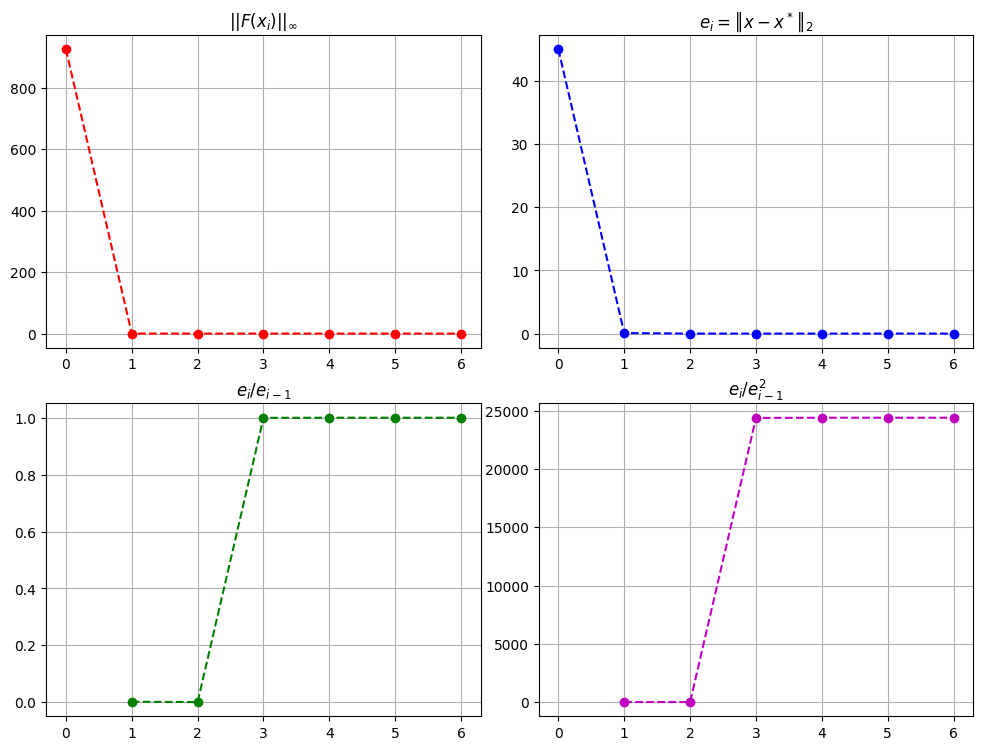

In [43]:
#define subplots
fig, ax = plt.subplots(2, 2, figsize=(10,6))
fig.tight_layout()


# plt.subplot(2, 2, 1)
ax[0, 0].plot(list(mnData["Step i"]), list(mnData["║F(xᵢ)║∞"]), 'ro--')
ax[0, 0].set_title(r'$\|\|F(x_{i})\|\|_{\infty}$')
ax[0, 0].grid()

# plt.subplot(2, 2, 2)
ax[0, 1].plot(list(mnData["Step i"]), list(mnData["eᵢ = ║x - x*║₂"]), 'bo--')
ax[0, 1].set_title(r'$e_i = ║x - x^*║_2$')
ax[0, 1].grid()

# plt.subplot(2, 2, 3)
ax[1, 0].plot(list(mnData["Step i"]), list(mnData["eᵢ / eᵢ̱ ₁"]), 'go--')
ax[1, 0].set_xlim(- 0.3, mnData["Step i"].max() + 0.3)
ax[1, 0].set_title(r'$e_i / e_{i-1}$')
ax[1, 0].grid()

# plt.subplot(2, 2, 4)
ax[1, 1].plot(list(mnData["Step i"]), list(mnData["eᵢ / e²ᵢ̱ ₁"]), 'mo--')
ax[1, 1].set_xlim(- 0.3, mnData["Step i"].max() + 0.3)
ax[1, 1].set_title(r'$e_i / e^2_{i-1}$')
ax[1, 1].grid()

plt.subplots_adjust(top=1.2)

plt.show()

# <a name="Section-2">2 Quadratic Formula</a>
[top](#Contents)

We modify the original nonlinear systems of equations into the following form.

\begin{align*}
    \text{\textbf{\textit{(1)}}  }  (x - A_1)^2 + (y - B_1)^2 +(z - C_1)^2 - [c(t_1 - d)]^2 &= 0 \\
    \text{\textbf{\textit{(2)}}  }  (x - A_2)^2 + (y - B_2)^2 +(z - C_2)^2 - [c(t_2 - d)]^2 &= 0 \\
    \text{\textbf{\textit{(3)}}  }  (x - A_3)^2 + (y - B_3)^2 +(z - C_3)^2 - [c(t_3 - d)]^2 &= 0 \\
    \text{\textbf{\textit{(4)}}  }  (x - A_4)^2 + (y - B_4)^2 +(z - C_4)^2 - [c(t_4 - d)]^2 &= 0
\end{align*}

The given system is modified by exponentiating the individual brackets in each of the equations and converting each term with the speed of light to the right-hand side.

\begin{align*}
    \text{\textbf{\textit{(1)}}  }  x^2 + y^2 + z^2 + A_1^2 + B_1^2 + C_1^2 -2 (A_1 x + B_1 y + C_1 z) &= c^2(t_1^2 - 2 t_1 d + d^2) \\
    \text{\textbf{\textit{(2)}}  } x^2 + y^2 + z^2 + A_2^2 + B_2^2 + C_2^2 -2 (A_2 x + B_2 y + C_2 z) &= c^2(t_2^2 - 2 t_2 d + d^2) \\
    \text{\textbf{\textit{(3)}}  }  x^2 + y^2 + z^2 + A_3^2 + B_3^2 + C_3^2 -2 (A_3 x + B_3 y + C_3 z) &= c^2(t_3^2 - 2 t_3 d + d^2) \\
    \text{\textbf{\textit{(4)}}  }  x^2 + y^2 + z^2 + A_4^2 + B_4^2 + C_4^2 -2 (A_4 x + B_4 y + C_4 z) &= c^2(t_4^2 - 2 t_4 d + d^2)
\end{align*}


We subtract $\text{\textbf{\textit{(2)}}}$ from $\text{\textbf{\textit{(1)}}}$.

\begin{align*}
    A_1^2 - A_2^2 + B_1^2 - B_2^2 + C_1^2 - C_2^2 + 2x (A_2 - A_1) + 2 y(B_2 - B_1) + 2z (C_2 - C_1) &= c^2 (t_1^2 - t_2^2 + 2d (t_2 - t_1))
\end{align*}

We subtract $\text{\textbf{\textit{(3)}}}$ from $\text{\textbf{\textit{(1)}}}$.

\begin{align*}
    A_1^2 - A_3^2 + B_1^2 - B_3^2 + C_1^2 - C_3^2 + 2x (A_3 - A_1) + 2 y(B_3 - B_1) + 2z (C_3 - C_1) &= c^2 (t_1^2 - t_3^2 + 2d (t_3 - t_1))
\end{align*}

We subtract $\text{\textbf{\textit{(4)}}}$ from $\text{\textbf{\textit{(1)}}}$.

\begin{align*}
    A_1^2 - A_4^2 + B_1^2 - B_4^2 + C_1^2 - C_4^2 + 2x (A_4 - A_1) + 2 y(B_4 - B_1) + 2z (C_4 - C_1) &= c^2 (t_1^2 - t_4^2 + 2d (t_4 - t_1))
\end{align*}

We can get a matrix form of these equations $Au=b$

\begin{align*}

        \begin{bmatrix} 
                2(A_2 - A_1) &  2(B_2  - B_1) &  2(C_2 - C_1) & 2c^2(t_1 - t_2)
                \\[0.25em]
                2(A_3 - A_1) &  2(B_3  - B_1) &  2(C_3 - C_1) & 2c^2(t_1 - t_3)
                \\[0.25em]
                2(A_4 - A_1) &  2(B_4  - B_1) &  2(C_4 - C_1) & 2c^2(t_1 - t_4)
        \end{bmatrix}

        \begin{bmatrix} x  \\ y \\ z \\ d \end{bmatrix}

        = 
        \begin{bmatrix} 
                A_2^2 - A_1^2 + B_2^2 - B_1^2 + C_2^2 - C_1^2 + c^2(t_1^2 - t_2^2) 
                \\[0.25em]
                A_3^2 - A_1^2 + B_3^2 - B_1^2 + C_3^2 - C_1^2 + c^2(t_1^2 - t_3^2) 
                \\[0.25em] A_4^2 - A_1^2 + B_4^2 - B_1^2 + C_4^2 - C_1^2 + c^2(t_1^2 - t_4^2)
        \end{bmatrix} 

\end{align*}

Then we combine coefficient matrix $A$ and vector of constants $b$ be an Augmented Matrix.

$$
\left[
    \begin{array}{c|c}
        A & b
    \end{array}
\right]
$$

Then we make it in reduced row-echelon form.

$$
r = 
\left[
    \begin{array}{cccc|c}
        1 & 0 & 0 & r_{14} & r_{15} \\
        0 & 1 & 0 & r_{24} & r_{25} \\
        0 & 0 & 1 & r_{34} & r_{35} \\
    \end{array}
\right]

This matrix can simplify our calculations, allowing us to get the equation of $x, y, z$ corresponding to $d$.

$$
\text{\textbf{\textit{(5)}}  } x = -r_{14}d + r_{15} \\
\text{\textbf{\textit{(6)}}  } y = -r_{24}d + r_{25} \\
\text{\textbf{\textit{(7)}}  } z = -r_{34}d + r_{35} \\
$$

We take these equations back to $\text{\textbf{\textit{(1)}}}$ so that we can eliminate the $x, y, z$ and get an equation about $d$.

$$
(r_{14}^2 + r_{24}^2 + r_{34}^2 - c^2)d^2  + \\
+2(- r_{14}r_{15} - r_{24}r_{25} - r_{34}r_{35} + A_1 r_{14}  + B_1 r_{24}  + C_1 r_{34} + c^2 t_1)d +\\
+(r_{15}^2 + A_1^2  - 2r_{15}A_1 + r_{25}^2 + B_1^2  - 2r_{25}B_1 +r_{35}^2 + C_1^2  - 2r_{35}C_1 - c^2t_1^2) =0
$$

We use the substitution $a$, $b$, and $c$ for individual coefficients. Then this equation has the following form.

$$
a d^2 + b d + c = 0
$$

It is a quadratic equation about $d$. So we can use the quadratic formula to calculate the value of $d$.

$$
d_{1,2} = \frac{-b \pm \sqrt {b^2-4ac}}{2a}
$$

Finally take the $d$ back to $\text{\textbf{\textit{(5)}}}$, $\text{\textbf{\textit{(6)}}}$, $\text{\textbf{\textit{(7)}}}$, we can get the coordinate.

## <a name="Section-21">2.1 The Number and Correctness of the Solutions</a>

### __The given algorithm gives us two solutions through the quadratic equation. We have chosen such a solution that makes physical sense, i.e. it is not inside or outside of the planet Earth.__

## <a name="Section-22">2.2 The Quality of the Solution Using the Quadratic Formula</a>

### __Multivariate Newton Method has a few drawbacks compared to the method based on the Quadratic formula. First, it requires a derivative that can be computationally expensive. Secondly, it is an iterative method that uses an initial guess of the solution. If this guess is "enough far" from the true solution then convergence is not guaranteed for this method. In contrast, the method based on the Quadratic formula does not have these drawbacks due to this method deals with several algebraic operations and one matrix operation. Finally, calculate the roots of the quadratic equation. For these advantages, it is better to use the method based on the Quadratic formula.__

## <a name="Section-23">2.3 Solution by the Quadratic Formula</a>

In [44]:
print(f"Method of the Quadratic Formula:\n")

starting_time = time.time()

xr = gps.quaratic()

print(f"x* = \n{xr}")


print(f'\nExecution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

Method of the Quadratic Formula:

x* = 
[[-4.1772709570833314e+01]
 [-1.6789194106524739e+01]
 [ 6.3700595592233449e+03]
 [-3.2015658295941338e-03]]

Execution time: 0:00:00.002983 [hh:mm:ss]


# <a name="Section-4">4 The Problem of Four Unbunched Satellites</a>
[top](#Contents)

## <a name="Section-41">4.1 GPS Spherical Coordinates</a>

As a first step, we calculate the spherical coordinates according to the following formula.
$$
(\rho, \phi_i, \theta_i) = (\rho, i \frac{\pi}{8} , (i - 1) \frac{\pi}{2})\text{ , for } i = 1, 2, 3, 4
$$

In [45]:
gps.setSphericA()
gps.getSpheric()

(ρ, ɸ1, θ1) = (26570.0, 0.39269908169872414, 0.0)

(ρ, ɸ2, θ2) = (26570.0, 0.7853981633974483, 1.5707963267948966)

(ρ, ɸ3, θ3) = (26570.0, 1.1780972450961724, 3.141592653589793)

(ρ, ɸ4, θ4) = (26570.0, 1.5707963267948966, 4.71238898038469)



## <a name="Section-42">4.2 New Coordinates and Timing for the Satellites</a>

The next step is to convert the spherical coordinates to the Cartesian system.
\begin{align*}
            A_i &= \rho \cdot cos(\phi_i) \cdot cos(\theta_i) \\
            B_i &= \rho \cdot cos(\phi_i) \cdot sin(\theta_i) \\
            C_i &= \rho \cdot sin(\phi_i), \\
            R_i &= \sqrt{A_i^2 + B_i^2 + (C_i - 6,370)^2} \\
            t_i &= d + \frac{R_i}{c}\\
            d &= 0.0001 \\
            \rho &= 26,570 \\
            0 &\le \phi_i \le \frac{\pi}{2} \text{ and } 0 \le \theta_i \le 2\pi \\
            \text{ for } i &= 1, \ldots ,4      
\end{align*}

The coordinates in the Cartesian system then have the following form.

$$
[ A_i, B_i, C_i, t_i] \text{ for } i = 1, \ldots ,4  
$$

In [46]:
gps.setSatellitesFromSpheric()
gps.getSatellites()

Satellite #1:
[[2.4547479178824888e+04]
 [0.0000000000000000e+00]
 [1.0167898797940436e+04]
 [8.2955788323008886e-02]]

Satellite #2:
[[1.1504226207088529e-12]
 [1.8787827176126568e+04]
 [1.8787827176126568e+04]
 [7.5221187899139244e-02]]

Satellite #3:
[[-1.0167898797940437e+04]
 [ 1.2452084716951976e-12]
 [ 2.4547479178824888e+04]
 [ 6.9574836349750174e-02]]

Satellite #4:
[[-2.9886463068994169e-28]
 [-1.6269432726672588e-12]
 [ 2.6570000000000000e+04]
 [ 6.7479947230026718e-02]]



## <a name="Section-43">4.3 Plot the Position of the Four Satellites</a>

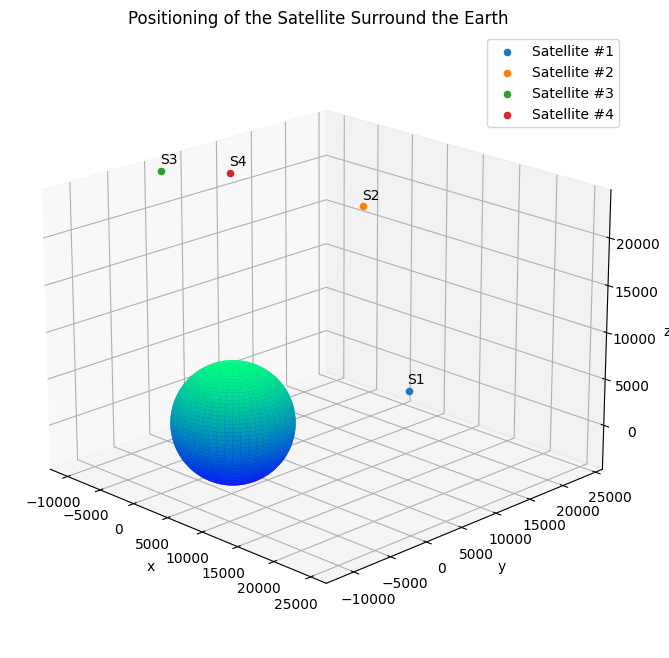

In [47]:
gps.plotSatellites()

## <a name="Section-44">4.4 Reference $\bar{x}$</a>

In [48]:
xtrue = np.array([[0.0],[0.0],[6370.0],[0.0001]], dtype = np.float)

print(f"x̄ = \n{xtrue}")

x̄ = 
[[0.00e+00]
 [0.00e+00]
 [6.37e+03]
 [1.00e-04]]


## <a name="Section-45">4.5 Difference in Position and Error Magnification Factor</a>

We first determined the time errors ($\Delta t_i$) that were added to the time components of individual satellites and calculated the resulting solutions. These errors have the following form.

\begin{align*}
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, +\epsilon, +\epsilon, -\epsilon) \\
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, +\epsilon, -\epsilon, -\epsilon) \\
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, -\epsilon, +\epsilon, -\epsilon) \\
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, -\epsilon, -\epsilon, -\epsilon)
\end{align*}                                
with $\epsilon = 10^{-8}$

For each case of time error $\Delta t_i$, we calculate the solution, and then the forward error, backward error and emf based on the reference vector x. <p>
$\text{forward error } =  \| (\Delta x, \Delta y, \Delta z ) \|_{\infty} \text{ (change in position) }$
<p>

$\text{backward error } = c \cdot \|(\Delta t_1, \ldots,\Delta t_m) \|_{\infty} \text{ (change in meters) }$ 
<p>

$emf = \frac{\text{forward error}}{\text{backward error}} = \frac{\| (\Delta x, \Delta y, \Delta z ) \|_{\infty}}{c  \|(\Delta t_1, \ldots,\Delta t_m) \|_{\infty}}  $

In [49]:
solutionsXr, fes, emfs, variationsDeltaT = gps.findEMF(xtrue)

In [50]:
for i in range(0, len(variationsDeltaT)):
    print(f"Case #{i + 1}:")
    print(f"Δt = {variationsDeltaT[i]}")
    print(f"xr = \n{solutionsXr[i]}")
    print(f"Difference in position: ║Δx, Δy, Δz║∞ = {fes[i]}")
    print(f"Error magnification factor = {emfs[i]}\n")

Case #1:
Δt = [ 1.e-08  1.e-08  1.e-08 -1.e-08]
xr = 
[[8.0030397434531497e-03]
 [1.6395658921178474e-03]
 [6.3700164145232611e+03]
 [1.0004475295049493e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.01641452326111903
Error magnification factor = 5.475295599704189

Case #2:
Δt = [ 1.e-08  1.e-08 -1.e-08 -1.e-08]
xr = 
[[-1.4148330101879936e-03]
 [-4.2685823049972704e-03]
 [ 6.3700054275014909e+03]
 [ 1.0000810419457843e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.005427501490885334
Error magnification factor = 1.8104196239937878

Case #3:
Δt = [ 1.e-08 -1.e-08  1.e-08 -1.e-08]
xr = 
[[8.0030397495733929e-03]
 [8.8267212463428307e-03]
 [6.3700164145236786e+03]
 [1.0004475294567973e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.016414523678577098
Error magnification factor = 5.475295738953212

Case #4:
Δt = [ 1.e-08 -1.e-08 -1.e-08 -1.e-08]
xr = 
[[-1.4148330109637342e-03]
 [ 2.9185765616369375e-03]
 [ 6.3700054275014381e+03]
 [ 1.0000810419518882e-04]]
Difference in position: ║Δx, 

## <a name="Section-46">4.6 Maximum Position Error</a>

In [51]:
print(f"The maximum position error found is {np.max(fes)*1000} [m].")

The maximum position error found is 16.414523678577098 [m].


## <a name="Section-47">4.7 Condition Number</a>

In [52]:
print(f"The condition number is aproximately {np.max(emfs)}.")

The condition number is aproximately 5.475295738953212.


# <a name="Section-5">5 Tightly Bounced Satellites</a>
[top](#Contents)

## <a name="Section-51">5.1 New GPS Spherical Coordinates</a>

As a first step, we calculate the spherical coordinates according to the following formula.
$$
(\rho, \phi_i, \theta_i) = (\rho, \frac{\pi}{2} + (i - 1) \frac{5}{100} \frac{\pi}{2} , (i - 1) \frac{5}{100} 2 \pi)\text{ , for } i = 1, 2, 3, 4
$$

In [53]:
gps.setSphericB()
gps.getSpheric()

(ρ, ɸ1, θ1) = (26570.0, 1.5707963267948966, 0.0)

(ρ, ɸ2, θ2) = (26570.0, 1.6493361431346414, 0.3141592653589793)

(ρ, ɸ3, θ3) = (26570.0, 1.7278759594743862, 0.6283185307179586)

(ρ, ɸ4, θ4) = (26570.0, 1.806415775814131, 0.942477796076938)



## <a name="Section-52">5.2 New Coordinates and Timing for the Satellites</a>

The given spherical coordinates are converted to the Cartesian system in the same way as in the section 4.2.

In [54]:
gps.setSatellitesFromSpheric()
gps.getSatellites()

Satellite #1:
[[1.6269432726672588e-12]
 [0.0000000000000000e+00]
 [2.6570000000000000e+04]
 [6.7479947230026718e-02]]

Satellite #2:
[[-1.9826277401445122e+03]
 [-6.4419480307068841e+02]
 [ 2.6488093557289209e+04]
 [ 6.7566048197813727e-02]]

Satellite #3:
[[-3.3626497990234034e+03]
 [-2.4431080857791821e+03]
 [ 2.6242879209612809e+04]
 [ 6.7823165827943163e-02]]

Satellite #4:
[[-3.6458222673459527e+03]
 [-5.0180438540261921e+03]
 [ 2.5835868784966267e+04]
 [ 6.8247792155330125e-02]]



## <a name="Section-53">5.3 Plot the Position of the Four Satellites</a>

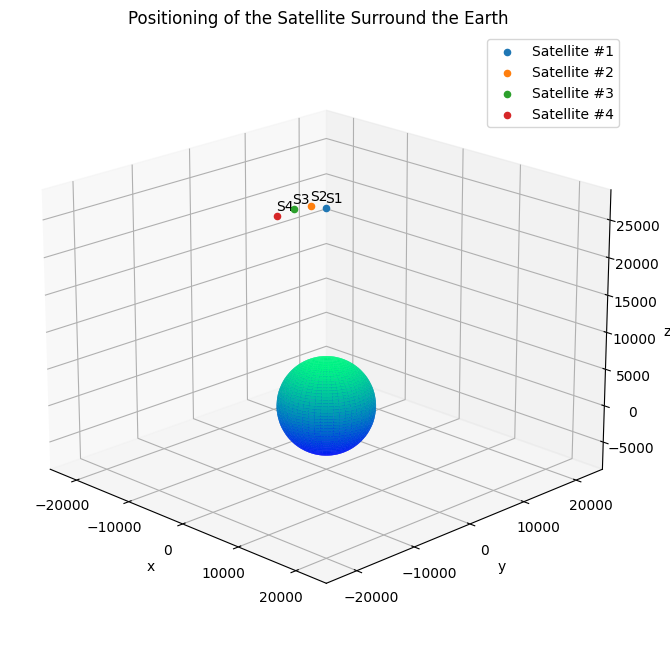

In [55]:
gps.plotSatellites()

## <a name="Section-54">5.4 Reference $\bar{x}$</a>

In [56]:
xtrue = np.array([[0.0],[0.0],[6370.0],[0.0001]], dtype = np.float)

print(f"x̄ = \n{xtrue}")

x̄ = 
[[0.00e+00]
 [0.00e+00]
 [6.37e+03]
 [1.00e-04]]


## <a name="Section-55">5.5 The Difference in Position and the Error Magnification Factor</a>

We use the same timing errors as in Section 4.5.

\begin{align*}
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, +\epsilon, +\epsilon, -\epsilon) \\
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, +\epsilon, -\epsilon, -\epsilon) \\
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, -\epsilon, +\epsilon, -\epsilon) \\
            (\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4) &= (+\epsilon, -\epsilon, -\epsilon, -\epsilon)
\end{align*}                                
with $\epsilon = 10^{-8}$

For each case of time error $\Delta t_i$, we calculate the solution, and then the forward error, backward error and emf based on the reference vector x. <p>
$\text{forward error } = \| (\Delta x, \Delta y, \Delta z ) \|_{\infty} \text{ (change in position) }$
<p>

$\text{backward error } = c \cdot \|(\Delta t_1, \ldots,\Delta t_m) \|_{\infty} \text{ (change in meters) }$ 
<p>

$emf = \frac{\text{forward error}}{\text{backward error}} = \frac{\| (\Delta x, \Delta y, \Delta z ) \|_{\infty}}{c  \|(\Delta t_1, \ldots,\Delta t_m) \|_{\infty}}  $

In [57]:
solutionsXr, fes, emfs, variationsDeltaT = gps.findEMF(xtrue)

In [58]:
for i in range(0, len(variationsDeltaT)):
    print(f"Case #{i + 1}:")
    print(f"Δt = {variationsDeltaT[i]}")
    print(f"xr = \n{solutionsXr[i]}")
    print(f"Difference in position: ║Δx, Δy, Δz║∞ = {fes[i]}")
    print(f"Error magnification factor = {emfs[i]}\n")

Case #1:
Δt = [ 1.e-08  1.e-08  1.e-08 -1.e-08]
xr = 
[[-9.8619251475383987e-03]
 [ 3.4928103518368975e-01]
 [ 6.3680926978188563e+03]
 [ 9.3647914656956518e-05]]
Difference in position: ║Δx, Δy, Δz║∞ = 1.9073021811436774
Error magnification factor = 636.2075263226527

Case #2:
Δt = [ 1.e-08  1.e-08 -1.e-08 -1.e-08]
xr = 
[[ 4.7234629629472419e-02]
 [-7.2593033561667064e-01]
 [ 6.3734719285808906e+03]
 [ 1.1159106345516874e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 3.4719285808905624
Error magnification factor = 1158.1107156773646

Case #3:
Δt = [ 1.e-08 -1.e-08  1.e-08 -1.e-08]
xr = 
[[ 3.7333603903533091e-01]
 [-9.3772272408136260e+01]
 [-1.1152925303701370e+04]
 [ 1.9331048047722105e-01]]
Difference in position: ║Δx, Δy, Δz║∞ = 17522.92530370137
Error magnification factor = 5845018.724153952

Case #4:
Δt = [ 1.e-08 -1.e-08 -1.e-08 -1.e-08]
xr = 
[[-9.2465483537997398e-02]
 [ 4.5504255202839333e-01]
 [ 6.3678546464850988e+03]
 [ 9.2853853158877638e-05]]
Difference in position: ║Δx

## <a name="Section-56">5.6 Maximum Position Error</a>

In [59]:
print(f"The maximum position error found is {np.max(fes)*1000} [m].")

The maximum position error found is 17522925.30370137 [m].


## <a name="Section-57">5.7 Condition Number</a>

In [60]:
print(f"The condition number is aproximately {np.max(emfs)}.")

The condition number is aproximately 5845018.724153952.


## <a name="Section-58">5.8 Comparison between tightly or loosely bunched satellites</a>

### __When those four satellites are tightly to each other, the maximum position error and condition number became significantly larger. This case belongs to ill-conditioned problems. Hence, the precision of the location is extensively reduced when using signals all from satellites that are tightly bounced.__

# <a name="Section-6">6 The Effect of Adding More Satellites</a>
[top](#Contents)

## <a name="Section-61">6.1 New GPS Spherical Coordinates</a>

As a first step, we calculate the spherical coordinates according to the following formula.
$$
(\rho, \phi_i, \theta_i) = (\rho, i \frac{\pi}{16} , (i - 1) \frac{\pi}{4})\text{ , for } i = 1, 2, \ldots , 8
$$

In [61]:
gps.setSphericC()
gps.getSpheric()

(ρ, ɸ1, θ1) = (26570.0, 0.19634954084936207, 0.0)

(ρ, ɸ2, θ2) = (26570.0, 0.39269908169872414, 0.7853981633974483)

(ρ, ɸ3, θ3) = (26570.0, 0.5890486225480862, 1.5707963267948966)

(ρ, ɸ4, θ4) = (26570.0, 0.7853981633974483, 2.356194490192345)

(ρ, ɸ5, θ5) = (26570.0, 0.9817477042468103, 3.141592653589793)

(ρ, ɸ6, θ6) = (26570.0, 1.1780972450961724, 3.9269908169872414)

(ρ, ɸ7, θ7) = (26570.0, 1.3744467859455345, 4.71238898038469)

(ρ, ɸ8, θ8) = (26570.0, 1.5707963267948966, 5.497787143782138)



## <a name="Section-62">6.2 New Coordinates and Timing for the Satellites</a>

The given spherical coordinates are converted to the Cartesian system in the same way as in the sections 4.2. and 5.2. 

In [62]:
gps.setSatellitesFromSpheric()
gps.getSatellites()

Satellite #1:
[[2.6059464900313833e+04]
 [0.0000000000000000e+00]
 [5.1835498559685275e+03]
 [8.7115062957788855e-02]]

Satellite #2:
[[1.7357688988382663e+04]
 [1.7357688988382663e+04]
 [1.0167898797940436e+04]
 [8.2955788323008886e-02]]

Satellite #3:
[[1.3527538921628798e-12]
 [2.2092147598878626e+04]
 [1.4761501091330831e+04]
 [7.8928491708490159e-02]]

Satellite #4:
[[-1.3284999999999998e+04]
 [ 1.3285000000000002e+04]
 [ 1.8787827176126568e+04]
 [ 7.5221187899139244e-02]]

Satellite #5:
[[-1.4761501091330832e+04]
 [ 1.8077625062108464e-12]
 [ 2.2092147598878626e+04]
 [ 7.2036083490136474e-02]]

Satellite #6:
[[-7.1897901904422297e+03]
 [-7.1897901904422279e+03]
 [ 2.4547479178824888e+04]
 [ 6.9574836349750174e-02]]

Satellite #7:
[[-9.5220266089988761e-13]
 [-5.1835498559685302e+03]
 [ 2.6059464900313833e+04]
 [ 6.8014847159579603e-02]]

Satellite #8:
[[ 1.1504226207088527e-12]
 [-1.1504226207088531e-12]
 [ 2.6570000000000000e+04]
 [ 6.7479947230026718e-02]]



## <a name="Section-63">6.3 Plot the Position of the Eight Satellites</a>

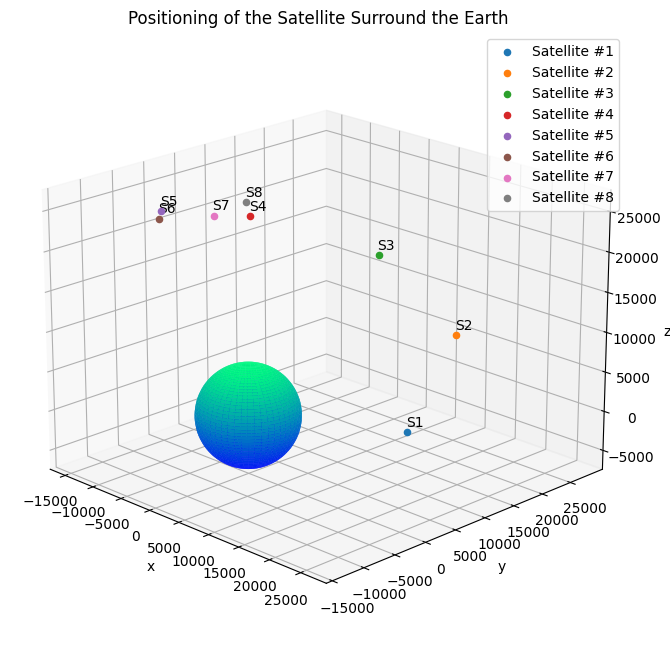

In [63]:
gps.plotSatellites()

## <a name="Section-64">6.4 Algorithm of Gauss–Newton Method</a>

Our implementation of the Gauss–Newton Method consists of five basic operations that take place in each step.
Basicly, it is very similar to the implementation of the Multivariate Newton's Method.  First, we calculate the Jacobi matrix for the given nonlinear system which is denote as the matrix A. Next, we use the QR decomposition of this matrix for the method of least squares. The QR decomposition is here for more numerical stability. This QR decompostion with unknown vector $s$ and vector $F(x_k)$ form a new inconsistent system (more equations than unknowns). Then, we solve the system through the nonlinear least square method. The solution of the previous step is subtracted from the initial solution. This gives us a new solution. At the end of each step, there is a check of the maximum number of iterations and the stopping condition. The backward error with $TOL = 10^{-16}$ serves as the stopping criterion.

##### <center>$x_0 = \text{initial vector}$</center>

\begin{align*}
\text{ \bf{for} } k &= 0, 1, 2, \ldots \\
        A &= J(x_k) \\
        A &= Q R \\
    R s &= Q^T F(x_k)  \\
    x_{k+1} &= x_k - s
\end{align*}

A small note, the goal of the Gauss-Newton Method is to minimize the sum of the squares of the individual components of the function $F$.

## <a name="Section-65">6.5 Reference $\bar{x}$</a>

In [64]:
xtrue = np.array([[0.0],[0.0],[6370.0],[0.0001]], dtype = np.float)

print(f"x̄ = \n{xtrue}")

x̄ = 
[[0.00e+00]
 [0.00e+00]
 [6.37e+03]
 [1.00e-04]]


## <a name="Section-66">6.6 Basic Case Sold by Gauss-Newton Method</a>

In [65]:
# The initial vector (x₀, y₀, z₀, d₀)
x0 = np.array([[0.0],[0.0],[6370.0],[0.0]], dtype = np.float)

In [66]:
print(f"Gauss-Newton Method:\n")

starting_time = time.time()

xr, gnData = gps.gaussNewton(x0)

print(f"x* = \n{xr}")

print(f'\nExecution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

print(f"\nThe number of iterations is {gnData['Step i'].max()}.")

Gauss-Newton Method:

x* = 
[[-6.9164304841547452e-15]
 [-2.3679079435967338e-15]
 [ 6.3700000000000000e+03]
 [ 1.0000000000000358e-04]]

Execution time: 0:00:00.001995 [hh:mm:ss]

The number of iterations is 1.


In [67]:
gnData

,Step i,xᵢ,yᵢ,zᵢ,dᵢ,"F(x,y,z,d)",║F(xᵢ)║∞,eᵢ = ║F(x*)║₂,eᵢ / eᵢ̱ ₁,eᵢ / e²ᵢ̱ ₁
0,0,0.000000e+00,0.000000e+00,6370.0,0.0000,"[-29.97924580000108, -29.97924580000108, -29.9...",29.979246,84.794112,NaN,NaN
1,1,-6.916430e-15,-2.367908e-15,6370.0,0.0001,"[0., 0., 0., 0., 0., 0., 0., 0.]",0.000000,0.000000,0.0,0.0


## <a name="Section-67">6.7 Initial Vector</a>

### __Universally, the Gauss-Newton Method is only locally convergent if the initial vector is that which is "close enough" to the true solution. It is hard to make a clear statement about what "close enough" means. Therefore a good initial vector is "close enough" to the true solution.__

## <a name="Section-68">6.8 Deciding on the Extremum of the Function $F(x, y, z, d)$</a>

### __We can check whether or not the found solution is a saddle point, maximum or minimum with a simple test. This is so that this solution enters $F(x^*, y^*, z^*, d^*)$, if the value of this function is zero or is almost zero in all dimensions, then we have found the minimum.__

## <a name="Section-69">6.9 The Difference in Position and the Error Magnification Factor</a>

We first determined the time errors ($\Delta t_i$) that were added to the time components of individual satellites and calculated the resulting solutions. These errors have the following form.

\begin{align*}
(\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4, \Delta t_5, \Delta t_6, \Delta t_7, \Delta t_8) &= (+\epsilon, +\epsilon, +\epsilon, -\epsilon, +\epsilon, +\epsilon, +\epsilon, -\epsilon) \\
(\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4, \Delta t_5, \Delta t_6, \Delta t_7, \Delta t_8) &= (+\epsilon, +\epsilon, -\epsilon, -\epsilon, +\epsilon, +\epsilon, -\epsilon, -\epsilon) \\
(\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4, \Delta t_5, \Delta t_6, \Delta t_7, \Delta t_8) &= (+\epsilon, -\epsilon, +\epsilon, -\epsilon, +\epsilon, -\epsilon, +\epsilon, -\epsilon) \\
(\Delta t_1, \Delta t_2, \Delta t_3, \Delta t_4, \Delta t_5, \Delta t_6, \Delta t_7, \Delta t_8) &= (+\epsilon, -\epsilon, -\epsilon, -\epsilon, +\epsilon, -\epsilon, -\epsilon, -\epsilon)
\end{align*}                                
with $\epsilon = 10^{-8}$

For each case of time error $\Delta t_i$, we calculate the solution, and then the forward error, backward error and emf based on the reference vector x. <p>
$\text{forward error } = \| (\Delta x, \Delta y, \Delta z ) \|_{\infty} \text{ (change in position) }$
<p>

$\text{backward error } =  c \cdot \|(\Delta t_1, \ldots,\Delta t_m) \|_{\infty} \text{ (change in meters) }$ 
<p>

$emf = \frac{\text{forward error}}{\text{backward error}} = \frac{\| (\Delta x, \Delta y, \Delta z ) \|_{\infty}}{c  \|(\Delta t_1, \ldots,\Delta t_m) \|_{\infty}}  $

In [68]:
solutionsXr, fes, emfs, variationsDeltaT = gps.findEMF(xtrue, x0, version = 2)

In [69]:
for i in range(0, len(variationsDeltaT)):
    print(f"Case #{i + 1}:")
    print(f"Δt = {variationsDeltaT[i]}")
    print(f"xr = \n{solutionsXr[i]}")
    print(f"Difference in position: ║Δx, Δy, Δz║∞ = {fes[i]}")
    print(f"Error magnification factor = {emfs[i]}\n")

Case #1:
Δt = [ 1.e-08  1.e-08  1.e-08 -1.e-08  1.e-08  1.e-08  1.e-08 -1.e-08]
xr = 
[[1.6432453442502114e-04]
 [2.6070290365558181e-03]
 [6.3700042267546341e+03]
 [1.0001484680926063e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.004226754634146346
Error magnification factor = 1.409893585163622

Case #2:
Δt = [ 1.e-08  1.e-08 -1.e-08 -1.e-08  1.e-08  1.e-08 -1.e-08 -1.e-08]
xr = 
[[2.1992823066411247e-03]
 [5.7285592143828442e-03]
 [6.3700094612113871e+03]
 [1.0002202842493002e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.009461211387133517
Error magnification factor = 3.155920415827645

Case #3:
Δt = [ 1.e-08 -1.e-08  1.e-08 -1.e-08  1.e-08 -1.e-08  1.e-08 -1.e-08]
xr = 
[[1.0201956174899654e-03]
 [2.2676758599545822e-03]
 [6.3700042146627511e+03]
 [1.0000962185145683e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.004214662751110154
Error magnification factor = 1.405860167139413

Case #4:
Δt = [ 1.e-08 -1.e-08 -1.e-08 -1.e-08  1.e-08 -1.e-08 -1.e-08 -1.e-08]
xr = 
[[3.0551531278

## <a name="Section-610">6.10 Maximum Position Error</a>

In [70]:
print(f"The maximum position error found is {np.max(fes)*1000} [m].")

The maximum position error found is 9.461211387133517 [m].


## <a name="Section-611">6.11 Condition Number</a>

In [71]:
print(f"The condition number is aproximately {np.max(emfs)}.")

The condition number is aproximately 3.155920415827645.


## <a name="Section-612">6.12 Other Combinations of Δt</a>

In [72]:
gps.setSatellitesFromSpheric()
solutionsXr, fes, emfs, variationsDeltaT = gps.findEMF(xtrue, x0, version = 3)

In [73]:
for i in range(0, len(variationsDeltaT)):
    print(f"Case #{i + 1}:")
    print(f"Δt = {variationsDeltaT[i]}")
    print(f"xr = \n{solutionsXr[i]}")
    print(f"Difference in position: ║Δx, Δy, Δz║∞ = {fes[i]}")
    print(f"Error magnification factor = {emfs[i]}\n")

Case #1:
Δt = [-1.e-08 -1.e-08 -1.e-08 -1.e-08 -1.e-08 -1.e-08 -1.e-08  1.e-08]
xr = 
[[-2.789415930438365e-03]
 [-1.766426513314101e-03]
 [ 6.369993468853797e+03]
 [ 9.997873352719097e-05]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.006531146203087701
Error magnification factor = 2.1785558738397954

Case #2:
Δt = [ 1.e-08  1.e-08  1.e-08  1.e-08 -1.e-08 -1.e-08 -1.e-08 -1.e-08]
xr = 
[[ 7.7398332812939988e-05]
 [-3.0108952678972421e-03]
 [ 6.3700052862813736e+03]
 [ 1.0000806502616321e-04]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.005286281373628299
Error magnification factor = 1.763313663357168

Case #3:
Δt = [-1.e-08 -1.e-08 -1.e-08 -1.e-08  1.e-08  1.e-08  1.e-08  1.e-08]
xr = 
[[-7.7399096431257777e-05]
 [ 3.0108955396658563e-03]
 [ 6.3699947137167328e+03]
 [ 9.9991934967110202e-05]]
Difference in position: ║Δx, Δy, Δz║∞ = 0.005286283267196268
Error magnification factor = 1.7633142949834544

Case #4:
Δt = [-1.e-08  1.e-08 -1.e-08  1.e-08 -1.e-08  1.e-08 -1.e-08  1.e-08]
xr = 
[[-1

In [74]:
print(f"The maximum position error found is {np.max(fes)*1000} [m].")
print(f"The condition number is aproximately {np.max(emfs)}.")

The maximum position error found is 6.531146203087701 [m].
The condition number is aproximately 2.1785558738397954.


## <a name="Section-613">6.13 Result of the Other Combinations of Δt</a>

### __Despite trying alternative variants of Δt, we did not detect a change for the worse in positional error or emf. On the contrary, these parameters have improved. This may be because we randomly selected such Δt that do not burden the resulting positions with a large error.__

# <a name="Section-7">7 Summary of the Results</a>
[top](#Contents)

### __If we look back and assess the deployment of the four unbunched and bunched satellites, we find that the unbunched satellites provide higher accuracy. Specifically, the four unbunched satellites have the maximum positional error of 16.41 meters and the condition number of approximately 5.47. In contrast, the four bunched satellites have a maximum position error of 17522925.3 meters and the condition number of approximately 5845018.72. From these numbers, we can see the "immense" difference between these two cases. When adding another four satellites (eight unbunched satellites together), we find that they have the maximum positional error of 9.46 meters and the condition number of approximately 3.16. When using other combinations of Δt, even the maximum positional error was reduced to the value of 6.53 meters and the maximum emf to the value of 2.17. Using eight satellites increased the accuracy by approximately twice compared to using four satellites. If we decide that accuracy is our criterion, and higher accuracy is always better then more satellites increase accuracy. It is clear that eight unbunched satellites give us the best accuracy over four unbunched or bunched satellites.__

# <a name="Section-8">References</a>
[top](#Contents)

* __The 3D Plotting: https://www.geeksforgeeks.org/three-dimensional-plotting-in-python-using-matplotlib/__